In [1]:
import pandas as pd
from pycaret.regression import *

df = pd.read_csv('consumption_temp.csv')

start_time = '2022-04-07 21:00:00'
end_time = '2022-06-07 21:00:00'
location = 'oslo'

start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

data = df[df['location'].str.lower() == location.lower()]
data['time'] = pd.to_datetime(data['time'])

# Filter the training data based on the start and end time
data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

# Create hour feature
data['hour'] = data['time'].dt.hour
# Create weekday feature
data['weekday'] = data['time'].dt.weekday

# Remove the last 5 days of consumption data
data['consumption'] = data['consumption'].shift(120)
data.dropna(subset=['consumption'], inplace=True)

In [2]:
regression_setup = setup(data=data, target='consumption', session_id=123,
                         numeric_features=['temperature', 'hour', 'weekday'], 
                         transform_target=True, data_split_shuffle=False)

,Description,Value
0,Session id,123
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(1345, 6)"
4,Transformed data shape,"(1345, 8)"
5,Transformed train set shape,"(941, 8)"
6,Transformed test set shape,"(404, 8)"
7,Numeric features,3
8,Date features,1
9,Categorical features,1


In [3]:
# Compare models to select the best one in the next block (comment if already selected)
#best_model = compare_models()


In [4]:
# Create the model with the desired model
lightgbm_model = create_model('lightgbm')
rf_model = create_model('rf')
et_model = create_model('et')

tuned_lightgbm_model = tune_model(lightgbm_model)
tuned_rf_model = tune_model(rf_model)
tuned_et_model = tune_model(et_model)


final_lightgbm_model = finalize_model(tuned_lightgbm_model)
final_rf_model = finalize_model(tuned_rf_model)
final_et_model = finalize_model(tuned_et_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0497,0.0036,0.0600,-0.8813,0.0284,0.0436
1,0.0058,0.0001,0.0077,-0.8458,0.0050,0.0107
2,0.0100,0.0002,0.0125,-0.9004,0.0079,0.0172
3,0.0237,0.0008,0.0289,-0.4638,0.0170,0.0347
4,0.0132,0.0003,0.0170,0.3804,0.0101,0.0197
5,0.0060,0.0001,0.0084,0.5476,0.0052,0.0097
6,0.0102,0.0002,0.0127,0.5104,0.0075,0.0147
7,0.0148,0.0003,0.0177,0.4143,0.0105,0.0218
8,0.0119,0.0002,0.0158,0.5846,0.0095,0.0179


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0480,0.0034,0.0582,-0.7736,0.0276,0.0421
1,0.0066,0.0001,0.0085,-1.2484,0.0055,0.0122
2,0.0107,0.0002,0.0135,-1.2247,0.0086,0.0183
3,0.0188,0.0006,0.0240,-0.0055,0.0141,0.0274
4,0.0136,0.0003,0.0175,0.3361,0.0105,0.0203
5,0.0068,0.0001,0.0088,0.5048,0.0054,0.0110
6,0.0133,0.0002,0.0154,0.2788,0.0092,0.0192
7,0.0193,0.0005,0.0233,-0.0115,0.0138,0.0284
8,0.0122,0.0003,0.0165,0.5434,0.0099,0.0183


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0443,0.0028,0.0533,-0.4879,0.0252,0.0389
1,0.0062,0.0001,0.0074,-0.7245,0.0048,0.0114
2,0.0072,0.0001,0.0092,-0.0316,0.0058,0.0122
3,0.0263,0.0010,0.0316,-0.7413,0.0185,0.0384
4,0.0129,0.0003,0.0169,0.3811,0.0101,0.0192
5,0.0091,0.0001,0.0108,0.2458,0.0067,0.0146
6,0.0106,0.0002,0.0130,0.4907,0.0077,0.0153
7,0.0165,0.0004,0.0202,0.2417,0.0120,0.0242
8,0.0111,0.0002,0.0141,0.6662,0.0085,0.0167


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1317,0.0193,0.1388,-9.0790,0.0673,0.1165
1,0.0166,0.0003,0.0176,-8.6395,0.0115,0.0308
2,0.0097,0.0001,0.0117,-0.6564,0.0074,0.0165
3,0.0316,0.0014,0.0379,-1.5144,0.0223,0.0463
4,0.0187,0.0005,0.0233,-0.1707,0.0139,0.0280
5,0.0112,0.0002,0.0133,-0.1338,0.0082,0.0179
6,0.0165,0.0004,0.0189,-0.0798,0.0112,0.0240
7,0.0273,0.0012,0.0343,-1.1998,0.0204,0.0409
8,0.0278,0.0011,0.0332,-0.8482,0.0199,0.0422


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0948,0.0110,0.1047,-4.7321,0.0502,0.0835
1,0.0116,0.0002,0.0130,-4.3147,0.0085,0.0214
2,0.0073,0.0001,0.0098,-0.1706,0.0062,0.0125
3,0.0441,0.0025,0.0496,-3.3060,0.0290,0.0644
4,0.0167,0.0004,0.0205,0.0934,0.0123,0.0251
5,0.0111,0.0002,0.0135,-0.1656,0.0083,0.0176
6,0.0129,0.0002,0.0156,0.2656,0.0092,0.0185
7,0.0208,0.0007,0.0256,-0.2263,0.0153,0.0310
8,0.0216,0.0007,0.0255,-0.0885,0.0153,0.0326


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1079,0.0135,0.1164,-6.0912,0.0560,0.0952
1,0.0136,0.0002,0.0146,-5.6639,0.0095,0.0251
2,0.0071,0.0001,0.0089,0.0403,0.0056,0.0122
3,0.0398,0.0021,0.0458,-2.6702,0.0269,0.0583
4,0.0184,0.0005,0.0231,-0.1463,0.0138,0.0276
5,0.0121,0.0002,0.0144,-0.3304,0.0089,0.0192
6,0.0147,0.0003,0.0164,0.1828,0.0097,0.0212
7,0.0242,0.0009,0.0303,-0.7111,0.0180,0.0361
8,0.0242,0.0008,0.0288,-0.3906,0.0173,0.0367


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


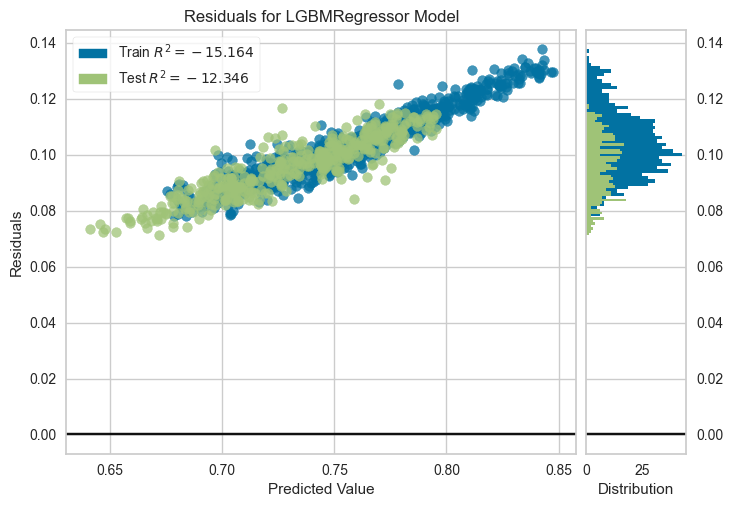

In [5]:
plot_model(final_lightgbm_model)

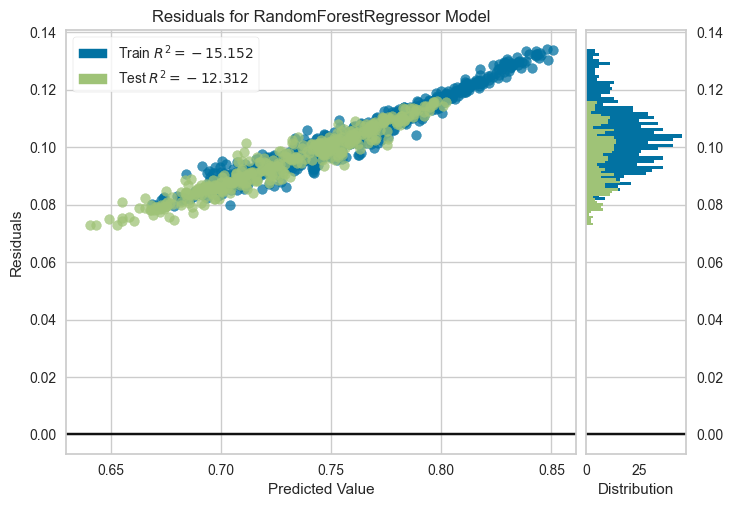

In [6]:
plot_model(final_rf_model)

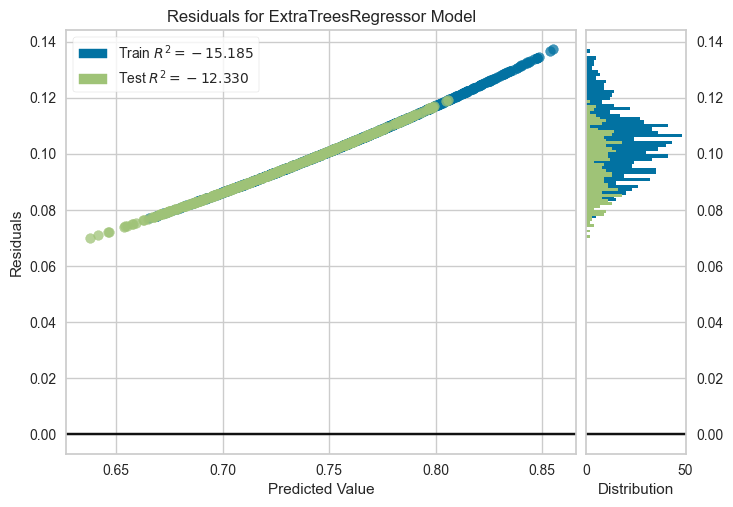

In [7]:
plot_model(final_et_model)

In [8]:
from datetime import timedelta

number_predict_hours = 24

# The last known time from the original data
last_time = data['time'].iloc[-1]

# Generating future timestamps for the next 24 hours (the hours we want to predict)
future_timestamps = [last_time + timedelta(hours=i) for i in range(1, number_predict_hours + 1)]

future_data = df[df['location'].str.lower() == location.lower()]
future_data['time'] = pd.to_datetime(future_data['time'])

# Limit future data to the next 24 hours after the last known time
future_data = future_data[(future_data['time'] > last_time) & (future_data['time'] <= future_timestamps[-1])]
future_hours = future_data['time'].dt.hour
future_weekdays = future_data['time'].dt.weekday
future_temperatures = future_data['temperature'].values

print(len(future_data))

# Creating the future_data DataFrame, which will be used for the prediction
future_data = pd.DataFrame({
    'time': future_timestamps,
    'temperature': future_temperatures,
    'location': location,
    'hour': future_hours,
    'weekday': future_weekdays
})

# Predict the consumption for the next 24 hours using the trained model
future_data['time'] = pd.to_datetime(future_data['time'])

24


In [9]:
predictions_lightgbm = predict_model(final_lightgbm_model, data=future_data)
predictions_lightgbm

,time,temperature,location,hour,weekday,prediction_label
7326,2022-06-07 22:00:00,13.500000,oslo,22,1,2.549948
7331,2022-06-07 23:00:00,13.200000,oslo,23,1,2.371909
7336,2022-06-08 00:00:00,12.600000,oslo,0,2,2.104821
7341,2022-06-08 01:00:00,12.900000,oslo,1,2,2.056988
7346,2022-06-08 02:00:00,13.400000,oslo,2,2,2.075851
7351,2022-06-08 03:00:00,12.900000,oslo,3,2,2.055490
7356,2022-06-08 04:00:00,12.900000,oslo,4,2,2.239036
7361,2022-06-08 05:00:00,12.900000,oslo,5,2,2.496340
7366,2022-06-08 06:00:00,13.000000,oslo,6,2,2.554738
7371,2022-06-08 07:00:00,14.200000,oslo,7,2,2.444315


In [10]:
predictions_rf = predict_model(final_rf_model, data=future_data)
predictions_rf

,time,temperature,location,hour,weekday,prediction_label
7326,2022-06-07 22:00:00,13.500000,oslo,22,1,2.541451
7331,2022-06-07 23:00:00,13.200000,oslo,23,1,2.333004
7336,2022-06-08 00:00:00,12.600000,oslo,0,2,2.101069
7341,2022-06-08 01:00:00,12.900000,oslo,1,2,2.071999
7346,2022-06-08 02:00:00,13.400000,oslo,2,2,2.086837
7351,2022-06-08 03:00:00,12.900000,oslo,3,2,2.053392
7356,2022-06-08 04:00:00,12.900000,oslo,4,2,2.228935
7361,2022-06-08 05:00:00,12.900000,oslo,5,2,2.468395
7366,2022-06-08 06:00:00,13.000000,oslo,6,2,2.508676
7371,2022-06-08 07:00:00,14.200000,oslo,7,2,2.493373


In [11]:
predictions_et = predict_model(final_et_model, data=future_data)
predictions_et

,time,temperature,location,hour,weekday,prediction_label
7326,2022-06-07 22:00:00,13.500000,oslo,22,1,2.604656
7331,2022-06-07 23:00:00,13.200000,oslo,23,1,2.362714
7336,2022-06-08 00:00:00,12.600000,oslo,0,2,2.139281
7341,2022-06-08 01:00:00,12.900000,oslo,1,2,2.064659
7346,2022-06-08 02:00:00,13.400000,oslo,2,2,2.083679
7351,2022-06-08 03:00:00,12.900000,oslo,3,2,2.088947
7356,2022-06-08 04:00:00,12.900000,oslo,4,2,2.278596
7361,2022-06-08 05:00:00,12.900000,oslo,5,2,2.564719
7366,2022-06-08 06:00:00,13.000000,oslo,6,2,2.522035
7371,2022-06-08 07:00:00,14.200000,oslo,7,2,2.407785


In [12]:
import pandas as pd
from pycaret.regression import *

solution = df[df['location'].str.lower() == location.lower()]
solution['time'] = pd.to_datetime(solution['time'])

# Filter the training data based on the start and end time
solution = solution[(solution['time'] > last_time) & (solution['time'] <= future_timestamps[-1])]

# Create hour feature
solution['hour'] = solution['time'].dt.hour
# Create weekday feature
solution['weekday'] = solution['time'].dt.weekday
# Merge the DataFrames
merged_data_lightgbm = predictions_lightgbm.copy()
merged_data_et = predictions_et.copy()
merged_data_rf = predictions_rf.copy()
merged_data_lr['consumption'] = solution['consumption']
merged_data_rf['consumption'] = solution['consumption']
merged_data_et['consumption'] = solution['consumption']

NameError: name 'merged_data_lr' is not defined

In [ ]:
merged_data_lightgbm.plot(x='time', y=['prediction_label', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours with Light Gradient Boosting Machine')

NameError: name 'merged_data_lightgbm' is not defined

<Axes: title={'center': 'Predictions for the next 24 hours with Random Forest'}, xlabel='time', ylabel='MV'>

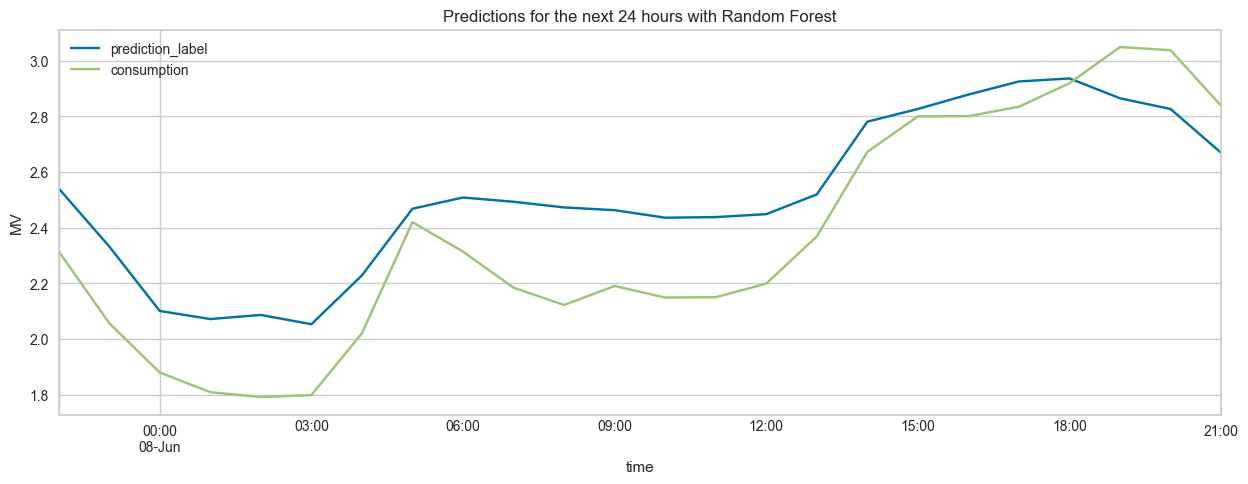

In [ ]:
merged_data_rf.plot(x='time', y=['prediction_label', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours with Random Forest')

<Axes: title={'center': 'Predictions for the next 24 hours with Extra Trees'}, xlabel='time', ylabel='MV'>

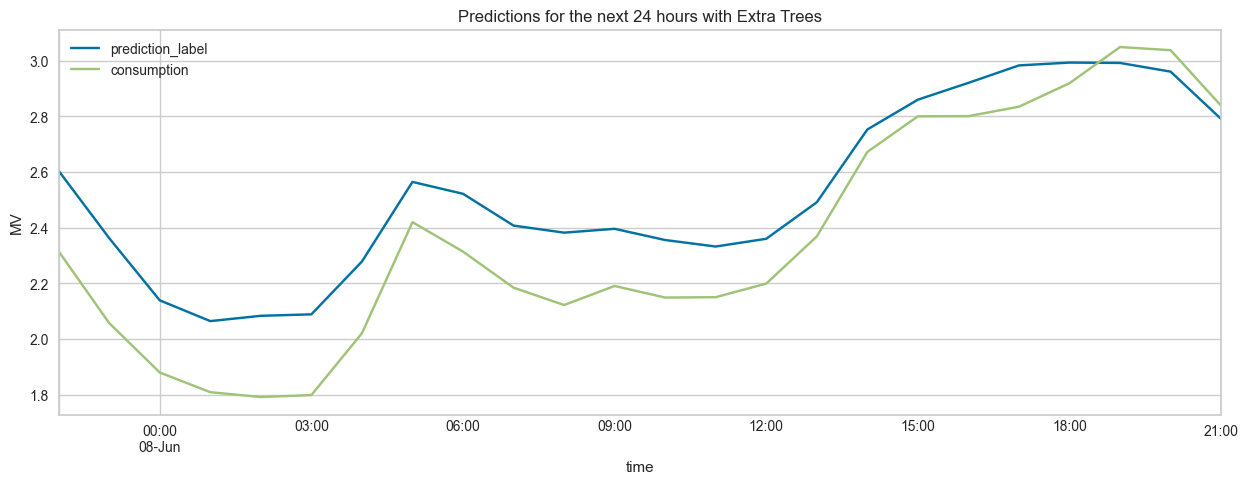

In [ ]:
merged_data_et.plot(x='time', y=['prediction_label', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours with Extra Trees')